# Użyte biblioteki

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from matplotlib import patches 
from numba import njit
import scipy.stats as stats
import seaborn as sns
from scipy import integrate

# Zadanie 1 - Szum telegraficzny

Zadanie polega na wygenerowaniu trajektorii szumu telegraficznego. Następnie należy numerycznie oszacować średnią wartość procesu oraz funkcję kowariancji. Poniżej znajduje się implementacja wymienionych funkcjonalności.

Trajektorie procesu do wykresów średniej i kowariancji były generowane w czasie $t_{max} = 200$ oraz z parametrem $\lambda = 1$. Wygenerowano $20000$ trajektorii.

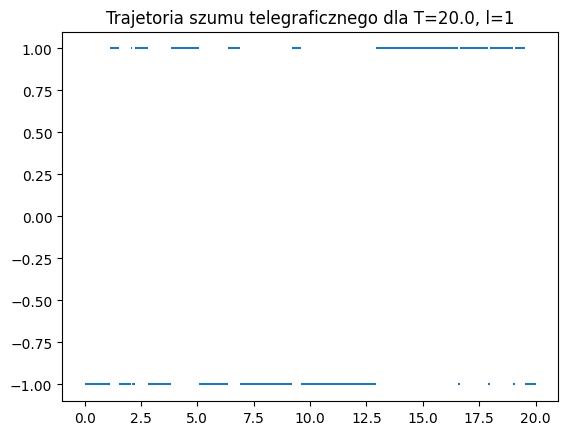

Średnia z tej trajektorii: -0.041594308373914445


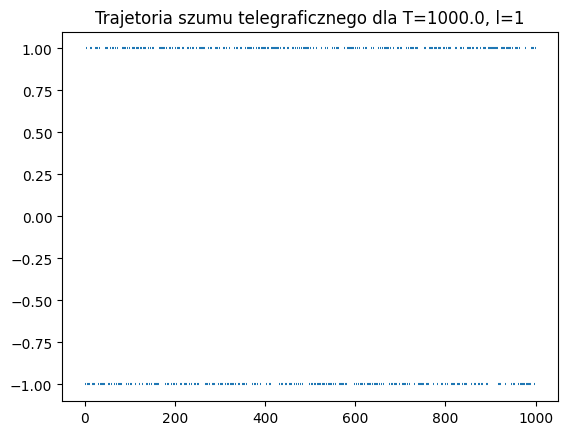

Średnia z tej trajektorii: 0.0541094214888806


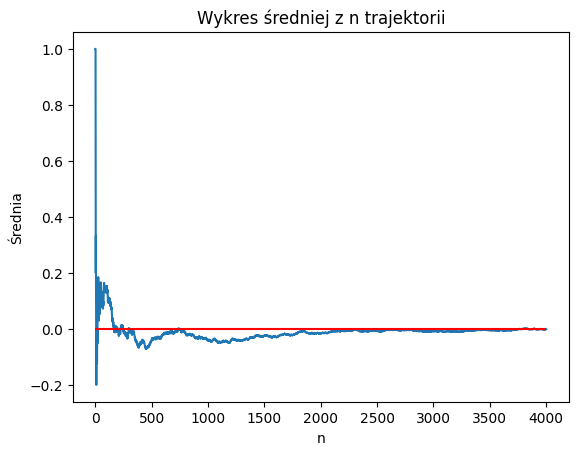

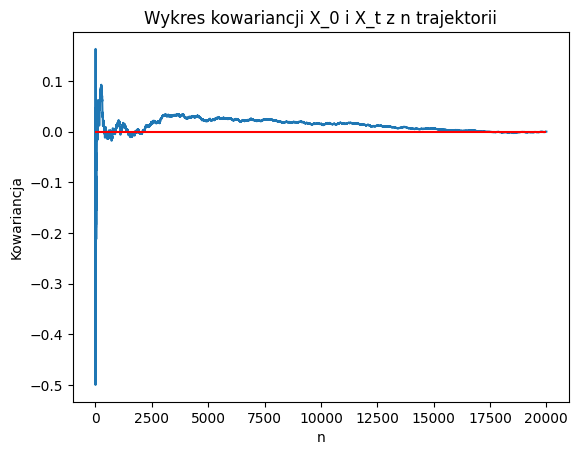

In [22]:
def telegraph_noise(tmax: int, lam=1):
    '''
    tmax - czas, na którym tworzymy proces\\
    lam - parametr lambda dla procesu Poissona\\
    \\
    Zwraca momenty skoków oraz wartości, które w nich przyjmuje.
    '''
    num_jumps = np.random.poisson(lam*tmax)
    D = np.random.choice([-1, 1])
    ts = np.sort(np.random.uniform(0, tmax, size=num_jumps+2))
    ts[0] = 0
    ts[-1] = tmax
    Ns = np.arange(0, num_jumps+1)
    return ts, D * (-1)**Ns

def draw_telegraph_noise(ts: np.ndarray, Xs: np.ndarray, lam=1):
    '''
    ts - momenty skoków\\
    Xs - wartości po wykonaniu skoków\\
    \\
    Rysuje trajektorię szumu telegraficznego.
    '''

    for i in range(len(ts)-1):
        plt.hlines(Xs[i], ts[i], ts[i+1])
    plt.title(f'Trajetoria szumu telegraficznego dla T={ts[-1]}, l={lam}')
    plt.show()

def mean_over_time(ts, Xs):
    '''
    ts - momenty skoków\\
    Xs - wartości po wykonaniu skoków\\
    \\
    Zwraca średnią po czasie liczoną z jednej trajektorii.
    '''
    s = 0
    for i in range(len(ts)-1):
        s += (ts[i+1] - ts[i])*Xs[i]
    return s/ts[-1]

def means_cov(N, tmax, lam=1):
    '''
    N - liczba trajektorii\\
    tmax - czas, na którym tworzymy proces\\
    lam - parametr lambda dla procesu Poissona\\
    \\
    Zwraca średnie po zespole liczoną z N trajektorii oraz kowariancję X_0 i X_tmax.
    '''
    X_t = np.empty(N)
    X_0 = np.empty(N)
    means = np.empty(N)
    cov = np.empty(N)
    
    for i in range(N):
        Xs = telegraph_noise(tmax, lam)[1]
        X_t[i] = Xs[-1]
        X_0[i] = Xs[0]
        means[i] = np.mean(X_t[:i+1])
        cov[i] = np.mean(np.multiply(X_t[:i+1], X_0[:i+1])) - np.mean(X_t[:i+1]) * np.mean(X_0[:i+1])
    return means, cov

# Przykładowa trajektoria
ts, Xs = telegraph_noise(20)
draw_telegraph_noise(ts, Xs)
print(f'Średnia z tej trajektorii: {mean_over_time(ts, Xs)}')

# Przykładowa trajektoria
ts, Xs = telegraph_noise(1000)
draw_telegraph_noise(ts, Xs)
print(f'Średnia z tej trajektorii: {mean_over_time(ts, Xs)}')

#Średnia i kowariancja
N = 20000
tmax = 200
means, covariance = means_cov(N, tmax)
plt.plot(np.arange(1, N//5+1), means[:N//5])
plt.hlines(0, 1, N//5, color='red')
plt.title(f'Wykres średniej z n trajektorii')
plt.xlabel('n')
plt.ylabel('Średnia')
plt.show()

plt.plot(np.arange(1, N+1), covariance)
plt.hlines(0, 1, N, color='red')
plt.title(f'Wykres kowariancji X_0 i X_t z n trajektorii')
plt.xlabel('n')
plt.ylabel('Kowariancja')
plt.show()

Na podstawie dwóch pierwszych wykresów można stwierdzić, że algorytm jest zaimplementowany poprawnie. Można zauważyć, że wraz ze wzrostem czasu średnia z pojedynczej trajektorii dąży do zera. W przypadku wielu trajektorii, ich średnia oraz kowariancja dążą do zera wraz ze wzrostem liczby trajektorii. Z wykresów można zauważyć, że średnia dąży do zera szybciej od kowariancji. Średnia stabilizuje się wokół zera dla około $1500$ trajektorii, natomiast w przypadku kowariancji stabilizacja następuje dla około $10000$ trajektorii.

# Zadanie 2 - Efektywnośc generacji niejednorodnego procesu Poissona

Zadanie polega na zaimplementowaniu niejednorodnego procesu Poissona dwoma metodami: metodą przerzedzania oraz metodą odwrotnej dystrybuanty. Następnie należało porównać efektywność obu metod. Poniżej znajduje się implementacja obu metod wraz z funkcją obliczającą wydajność metody przerzedzania.

In [3]:
def pois_thinning(lam, T):
    '''
    lam - funkcja intensywności lambda\\
    T - czas, w którym generujemy proces Poissona\\
    \\
    Generuje niejednorodny proces poissona o intensywności lam metodą przerzedzania.
    Zwraca krotkę zawierającą momenty skoków oraz liczbę wszystkich wygenerowanych skoków (w tym odrzuconych). 
    '''
    ts = [0]
    t = 0
    lmax = np.max(lam(np.arange(0, T, T/10**4)))
    i = 0
    while t<T:
        U = np.random.uniform()
        t += np.random.exponential(1/lmax)
        i += 1
        if U < lam(t)/lmax:
            ts.append(t)
    ts[-1] = T
    return ts, i

def pois_inv_dist(lam, T, inv):
    '''
    lam - funkcja intensywności lambda\\
    T - czas, w którym generujemy proces Poissona\\
    inv - funkcja odwrotnej dystrybuanty\\
    \\
    Generuje niejednorodny proces poissona o intensywności lam metodą odwrotnej dystrybuanty.
    '''
    X = np.random.uniform(size=np.random.poisson(m_t(lam, T)))
    ts = sorted(np.append(0,inv(X,T)))
    ts[-1]=T
    return ts

def m_t(lam, T):
    return integrate.quad(lam,0,T)[0]

def efficiency_thinning(lam, T, N=100):
    '''
    lam - funkcja intensywności lambda\\
    T - czas, w którym generujemy proces Poissona\\
    N - liczba wygenerowanych procesów\\
    \\
    Zwraca procent zaakceptowanych punktów
    '''
    eff = []
    for _ in range(N):
        ts, i = pois_thinning(lam, T)
        eff.append((len(ts) - 1)/i)
    return np.sum(eff)/N

print('Wydajność metody dla funkcji:')
print('1:', efficiency_thinning(lambda x: 1, 7))
print('sqrt(x):', efficiency_thinning(lambda x: np.sqrt(x), 7))
print('x:', efficiency_thinning(lambda x: x, 7))
print('x^2:', efficiency_thinning(lambda x: x**2, 7))
print('exp(x):', efficiency_thinning(lambda x: np.exp(x), 7))

Wydajność metody dla funkcji:
1: 1.0
sqrt(x): 0.6830429874094064
x: 0.514270954656596
x^2: 0.34041779787973775
exp(x): 0.14297030584814008


W celu zmierzenia średniego czasu skorzystaliśmy z polecenia "%%timeit". Testowaliśmy czas wykonania obu metod dla funkcji $1, \sqrt{x}, x, x^2, e^{x}$. Otrzymaliśmy następujące wyniki:

In [4]:
%%timeit
pois_thinning(lambda x: 1,10)

79.7 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
%%timeit
pois_inv_dist(lam= lambda x: 1, T=10, inv= lambda U,T: U*T)

18.8 µs ± 291 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
%%timeit
pois_thinning(lambda x: np.sqrt(x),10)

256 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
pois_inv_dist(lam= lambda x: np.sqrt(x), T=10, inv= lambda U,T: U**(2/3)*T)

200 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
%%timeit
pois_thinning(lambda x: x,10)

617 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%%timeit
pois_inv_dist(lam= lambda x: x, T=10, inv= lambda U,T: U**(1/2)*T)

27.4 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
pois_thinning(lambda x: x**2,10)

6.04 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
pois_inv_dist(lam= lambda x: x**2, T=10, inv= lambda U,T: U**(1/3)*T)

116 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit
pois_thinning(lambda x: np.exp(x),10)

1.42 s ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
pois_inv_dist(lam= lambda x: np.exp(x), T=10, inv= lambda U,T: np.log(U*(np.exp(T)-1)+1))

9.64 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Z powyższych obliczeń wynika, że im szybciej zmienia się funkcja, tym mniej wydajna jest metoda przerzedzania, np. dla funkcji $\sqrt{x}$ wydajność wyniosła około $69\%$, natomiast dla funkcji $e^x$ wydajność wyniosła zaledwie $14\%$. Niska wydajność metody przerzedzania dla funkcji szybkozmiennych  prowadzi do dłuższego czasu wykonania, co można zaobserwować z powyższych pomiarach czasu. Jest to spowodowane dużą liczbą odrzuceń - obszar znajdujący się pomiędzy funkcją, a jej maksimum na danym przedziale jest dużo większy, niż obszar pod wykresem funkcji. Z tego powodu dla funkcji szybkozmiennych lepszym sposobem generowania niejednorodnego procesu Poissona będzie metoda odwrotnej dystrybuanty, co można zauważyć prównując rożnice czasów wykonania dla każdej z funkcji - w przypadku funkcji $e^x$ metoda odwrotnej dystrybuany wykonała się około 100 razy szybciej niż metoda przerzedzania. Jedyną wadą metody odwrotnej dystrybuanty jest konieczność znajomości funkcji odwrotnej do dystrybuanty, często może mieć ona skomplikowaną postać.

# Zadanie 3 - Estymacja niejednorodnej intensywności

Zadanie polega na zaimplementowaniu estymacji niejednorodnej funkcji intensywności losowej miary Poissonowskiej w jednym i dwóch wymiarach. W przypadku jednowymiarowym generowaliśmy miarę na zbiorze $[0, 10]$ dla funkcji intensywności zadanej wzorem
$$\begin{cases}
x^2 \qquad x \in [0, 5] \text{,}\\
x \qquad x \in (5, 10] \text{.}
\end{cases}$$
Poniżej znajduje się implementacja w jednym wymiarze.

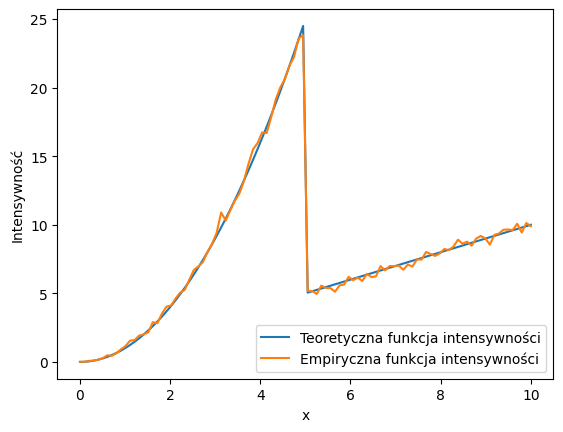

In [14]:
def generate_random_points(n):
    '''
    n - liczba punktów

    Zwraca listę punktów z przedziału [0, 10] o rozmieszczeniu zadanym funkcją intensywności.
    '''
    points = []
    for _ in range(n):
        x = np.random.uniform(0, 10)
        if x <= 5:
            intensity = x**2
        else:
            intensity = x
        u = np.random.uniform(0, 1)
        if u <= intensity/475*6: #unormowanie intensywności
            points.append(x)
    return points


def estimate_intensity_function(histogram, num_bins):
    '''
    histogram - liczba punktów, które wpadły do każdego z przedziałów
    num_bins - liczba przedziałów

    Zwraca etsymację funkcji intensywności na podstawie liczby punktów, które trafiły do danego przedziału.
    '''
    bin_width = 10 / num_bins
    intensities = histogram / (bin_width * len(points))
    return intensities*475/6 


def theoretical_intensity_function(x):
    '''  
    Zwraca teoretyczną wartość funkcji intensywności dla danego x.
    '''
    if x <= 5:
        return x**2
    else:
        return x

def create_intensity_histogram(points, num_bins):
    '''
    points - lista punktów
    num_bins - liczba przedziałow

    Zwraca liczbę punktów, która wpadła do każdego przedziału.
    '''
    bins = np.linspace(0,10, num_bins + 1)
    return np.histogram(points, bins)[0]

# Wygenerowanie danych losowych
points = generate_random_points(10**6)


# Tworzenie histogramu
num_bins = 100
histogram = create_intensity_histogram(points, num_bins)

# Estymacja funkcji intensywności
intensities = estimate_intensity_function(histogram, num_bins)

# Tworzenie wykresu teoretycznej funkcji intensywności
x_theoretical = np.linspace(0, 10, 100)
y_theoretical = [theoretical_intensity_function(x) for x in x_theoretical]

# Tworzenie wykresu empirycznej funkcji intensywności
x_empirical = np.linspace(0, 10, num_bins)
y_empirical = intensities

# Wyświetlanie wykresów
plt.plot(x_theoretical, y_theoretical, label='Teoretyczna funkcja intensywności')
plt.plot(x_empirical, y_empirical, label='Empiryczna funkcja intensywności')
plt.xlabel('x')
plt.ylabel('Intensywność')
plt.legend()
plt.show()

Na podstawie powyższego wykresu można stwierdzić, że empiryczna funkcja intensywności dobrze pokrywa się z teoretyczną funkcją intensywności, czyli wygenerowana niejednorodna miara Poissonowska ma prawidłową funkcję intensywności. 

W przypadku dwuwymiarowym generowaliśmy miarę na zbiorze $[0, 10] \times [0, 10]$. Tym razem przyjęliśmy funkcję intensywności opisaną wzorem
$$\begin{cases}
\sqrt{x^2+y^2} \qquad y < x \text{,}\\
x+y \qquad y \geq x \text{.}
\end{cases}$$

Poniżej znajduje się implemetacja.

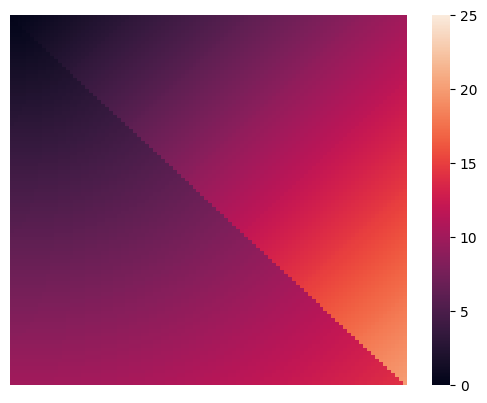

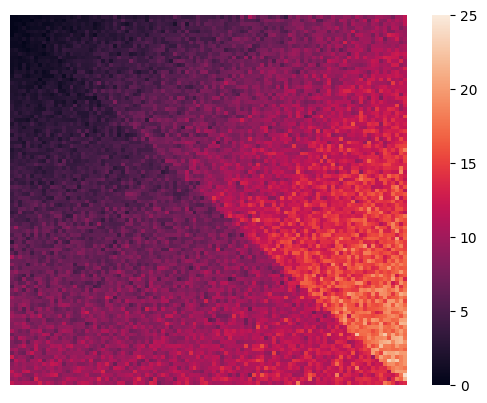

In [15]:
def generate_random_points_2d(n):
    '''
    n - liczba punktów

    Zwraca współrzędne x i y punktów ze zbioru [0, 10] x [0, 10] z rozmieszczeniem opisanym funkcją intensywności.
    '''
    Xs = []
    Ys = []
    for _ in range(n):
        x = np.random.uniform(0, 10)  # Przedział [0, 10]
        y = np.random.uniform(0, 10)
        if y < x:
            intensity = np.sqrt(x**2 + y**2)
        else:
            intensity = x + y
        u = np.random.uniform(0, 1)
        if u <= intensity/882.597858: #unormowanie intensywności
            Xs.append(x)
            Ys.append(y)
    return Xs, Ys


def estimate_intensity_function(Xs, histogram, num_bins):
    '''
    histogram - liczba punktów, które wpadły do każdego z obszarów
    num_bins - liczba obszarów (wzdłuż jednego wymiaru)

    Zwraca estymację funkcji intensywności na podstawie liczby punktów, które trafiły do poszczególnych obszarów.
    '''
    bin_width_sq = (10/num_bins)**2
    intensities = histogram / (bin_width_sq * len(Xs))
    return intensities*882.597858


def theoretical_intensity_function(x, y):
    '''  
    Zwraca teoretyczną wartość funkcji intensywności dla danej pary x, y.
    '''
    if y < x:
        return np.sqrt(x**2 + y**2)
    else:
        return x + y

def create_intensity_histogram(Xs, Ys, num_bins):
    '''
    Xs - współrzędne x punktów
    Ys - współrzędne y punktów
    num_bins - liczba przedziałów wzdóuż jednej osi

    Zwraca liczbę punktów, która wpadła do każdego przedziału.
    '''
    bins = np.linspace(0,10, num_bins + 1)
    return np.histogram2d(Xs, Ys, bins)[0]

# Wygenerowanie danych losowych
points = generate_random_points_2d(10**7*5)
Xs, Ys = points
# Tworzenie histogramu
num_bins = 100
histogram = create_intensity_histogram(Xs, Ys, num_bins)

# Estymacja funkcji intensywności
intensities = estimate_intensity_function(Xs, histogram, num_bins)

# Tworzenie wykresu teoretycznej funkcji intensywności
x_theoretical = np.linspace(0, 10, 100)
y_theoretical = np.linspace(0, 10, 100)
value_theoretical = np.empty((100, 100))
for x in range(len(x_theoretical)):
    for y in range(len(y_theoretical)):
        value_theoretical[x][y] = theoretical_intensity_function(x_theoretical[x], y_theoretical[y])


# Tworzenie wykresu empirycznej funkcji intensywności
x_empirical = np.linspace(0, 10, num_bins)
y_empirical = np.linspace(0, 10, num_bins)
value_empirical = intensities

# Wyświetlanie wykresów
sns.heatmap(value_theoretical,xticklabels=False, yticklabels=False,vmax=25)
plt.show()

sns.heatmap(value_empirical,xticklabels=False, yticklabels=False,vmax=25)
plt.show()


Na podstawie powyższych heatmap można stwierdzić, że wygenerowana miara Poissonowska ma pożądaną funkcję intensywności - oba wykresy wykazują duże podobieństwo.

# Zadanie 4 - Prawdopodobieństwo ruiny

Zadanie polega na zaimplementowaniu procesu ryzyka oraz obliczenia prawdopodobieństwa ruiny dla danych okresów czasu. W tym celu generujemy momenty, w których nastąpiła strata  rozkładu Poissona o parametrze . Następnie dla każdego z uzyskanych momentów wygenerowaliśmy wysokość straty z rozkładu wykładniczego z parametrem $1$. 

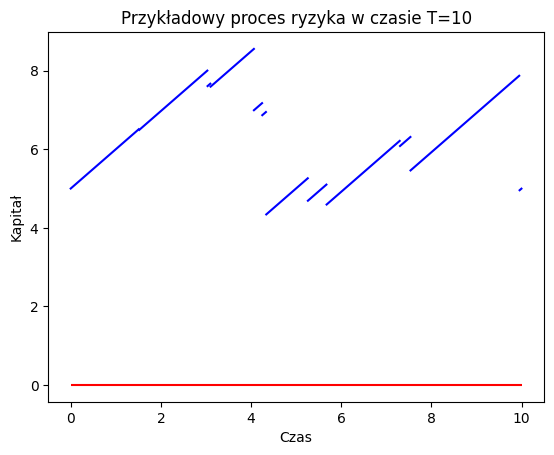

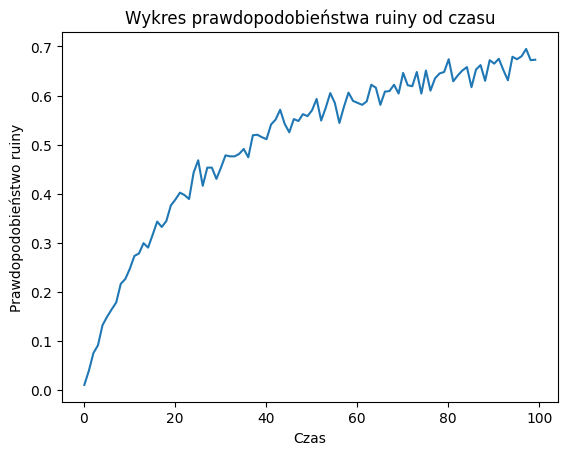

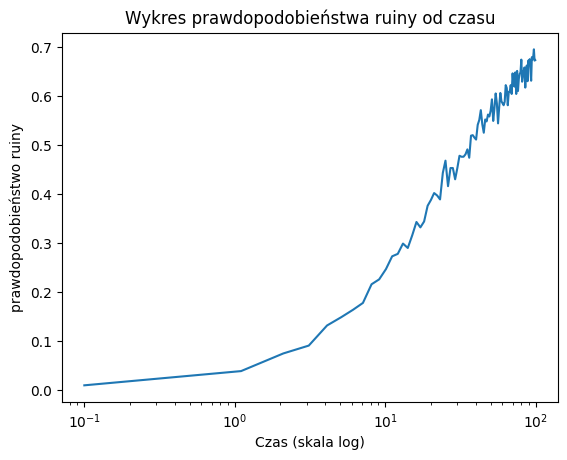

In [16]:
def risk_process(tmax, plot=True):
    '''
    tmax - czas, na którym liczymy proces \\
    plot - True/False - czy funkcja ma generować wykres \\
    \\
    Zwraca momenty, w których nastąpiły straty oraz budżet po każdej ze strat.
    '''
    U = 5
    A = 1
    ts = np.random.uniform(0, tmax, np.random.poisson(tmax)+2)
    ts[0] = 0
    ts[-1] = tmax
    ts = np.sort(ts)
    Us = [U]
    for i in range(np.size(ts)-1):
        value = np.random.exponential(1)
        U = U + A*(ts[i+1] - ts[i]) - value
        Us.append(U)
    
    if plot:
        for i in range(np.size(ts)-1):
            t_axis = np.arange(ts[i], ts[i+1], 0.01)
            U_axis = Us[i]+(t_axis-ts[i])*A
            plt.plot(t_axis, U_axis, color='blue')
        plt.hlines(0, 0, tmax, color='red')
        plt.title(f'Przykładowy proces ryzyka w czasie T={tmax}')
        plt.xlabel('Czas')
        plt.ylabel('Kapitał')
        plt.show()
    
    return ts, Us


def ruin_probability(N, t_check):
    '''
    N - liczba symulacji procesu ryzyka \\
    ts - czasy, w których sprawdzamy prawdopodobieństwo ruiny \\
    \\
    Zwraca prawdopodobieństwo ruiny dla zadanych czasów.
    '''
    ruin = 0
    for i in range(N):
        ts, Us = risk_process(t_check, plot=False)
        for j in range(np.size(ts)):
            if Us[j] < 0:
                ruin += 1
                break
    
    return ruin/N

# Przykładowe trajektorie
risk_process(10, True)
#risk_process(50, True)
#risk_process(100, True)

ts = np.arange(0.1, 100, 1)
N = 10**3
ruin_data = [ruin_probability(N, t) for t in ts]
plt.plot(ts, ruin_data)
plt.xlabel('Czas')
plt.ylabel('Prawdopodobieństwo ruiny')
plt.title('Wykres prawdopodobieństwa ruiny od czasu')
plt.show()

plt.plot(ts, ruin_data)
plt.xscale('log')
plt.xlabel('Czas (skala log)')
plt.ylabel('prawdopodobieństwo ruiny')
plt.title('Wykres prawdopodobieństwa ruiny od czasu')
plt.show()

Na podstawie wykresu trajektorii procesu ryzyka można stwierdzić prawidłową implementację. Z wykresu prawdopodobieństwa ruiny od czasu wynika, że prawdopodobieństwo ruiny rośnie z czasem, w czasie $100$ osiąga wartość około $70%$. W celu sprawdzenia jak szybko prawdopodobieństwo ruiny dąży do 1 sporządziliśmy wykres, na którym czas jest w skali logarytmicznej. Mozna zauważyć, że pomijając pierwsze 3 punkty zależność na ostatnim wykresie jest zbliżona do liniowej, co świadczy o tym, że prawdopodobieństwo ruiny na pewnym odcinku czasu rośnie logarytmicznie.

# Zadanie 5 - Rozkład stacjonarny łańcucha Markowa

Zadanie polega na wygenerowaniu trajektorii łańcucha Markowa oraz przeanalizowanie, czy łańcuch osiąga stan stacjonarny niezależnie od stanu początkowego. Następnie należało utworzyć reprezentację graficzną łańcucha oraz sprawdzić, jak szybko łańcuch osiąga stan stacjonarny

Poniżej znajduje się implementacja wszystkich potrzebnych funkcji wraz z wygenerowanymi wykresami oraz grafem przedstawiającym badany łańcuch.

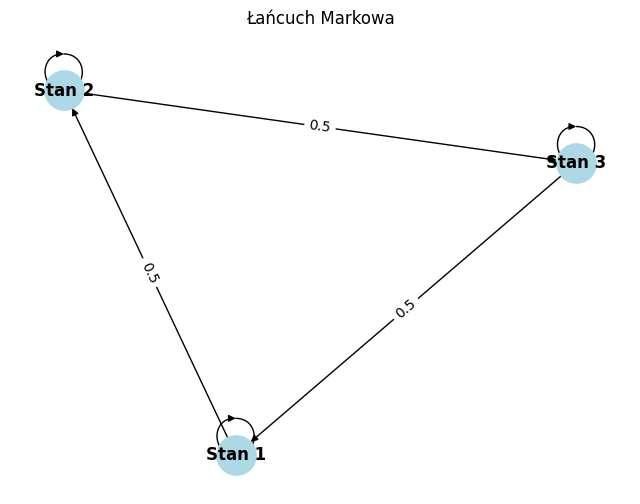

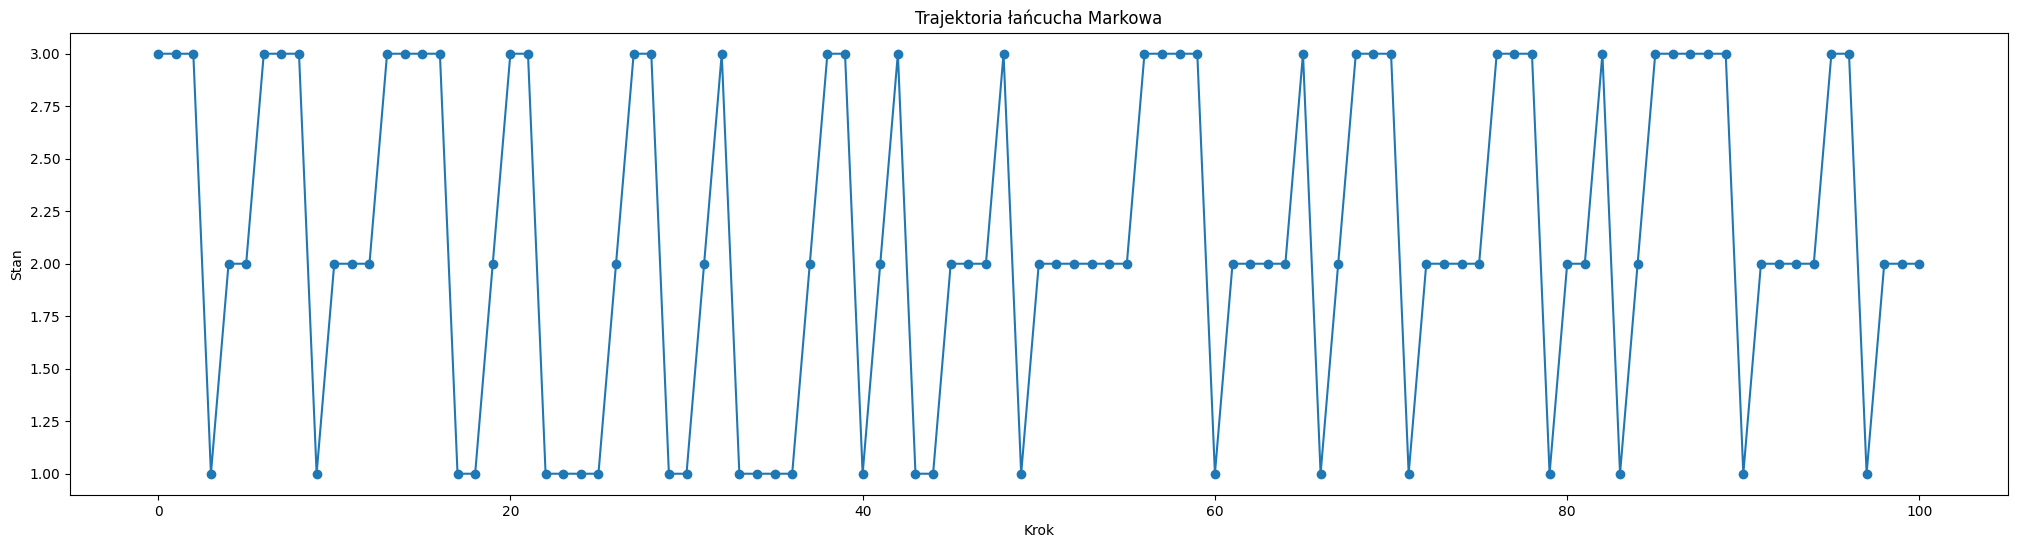

Prawdopodobieństwa empiryczne dla stanu poczatkowego 1: [0.33523352 0.33323332 0.33163316]
Prawdopodobieństwa empiryczne dla stanu poczatkowego 2: [0.33833383 0.33843384 0.32333233]
Prawdopodobieństwa empiryczne dla stanu poczatkowego 3: [0.3270327  0.33443344 0.33863386]
Prawdopodobieństwa stacjonarne: [0.33333333 0.33333333 0.33333333]


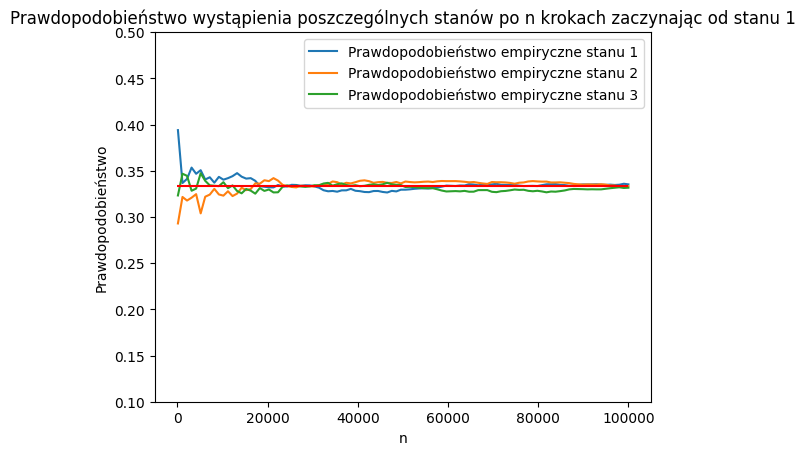

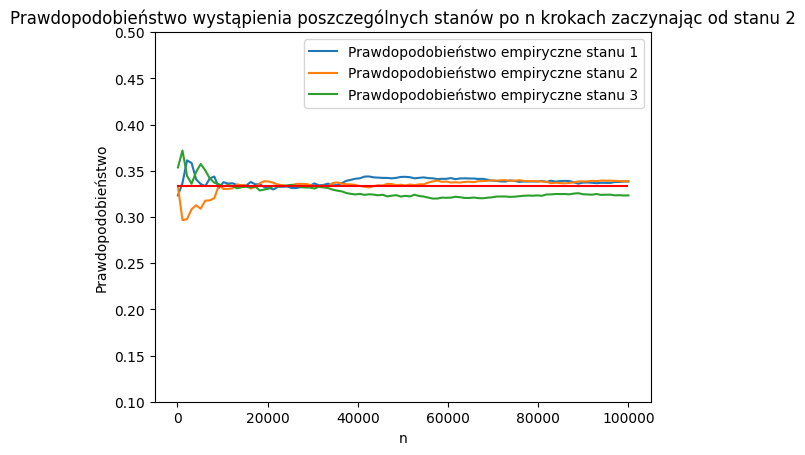

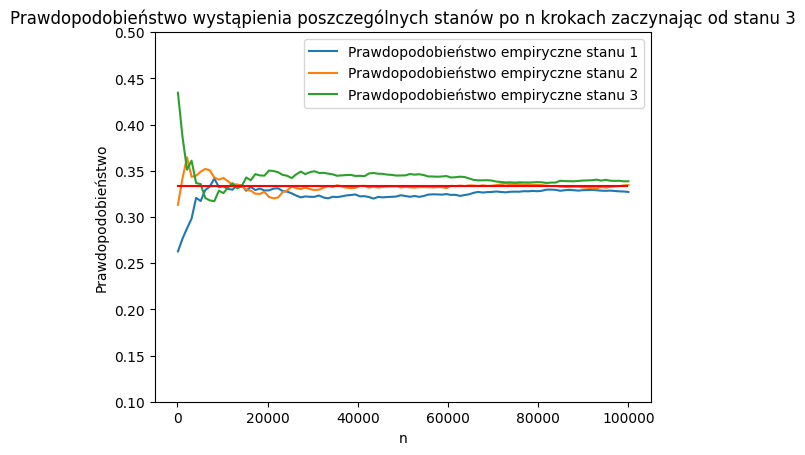

In [17]:
def simulate_markov_chain(tr_matrix, N, init_state):
    '''
    tr_matrix - macierz przejścia
    N - liczba kroków
    init_state - stan początkowy

    Zwraca trajektorię łańcucha Markowa.
    '''
    num_states = np.size(tr_matrix[0])
    current_state = init_state
    chain = np.empty(N+1)
    chain[0] = current_state
    
    for i in range(1, N+1):
        probabilities = tr_matrix[current_state - 1]
        next_state = np.random.choice(range(1, num_states + 1), p=probabilities)
        chain[i] = next_state
        current_state = next_state
    
    return chain

def gen_graph(tr_matrix):
    '''
    tr_matrix - macierz przejścia

    Rysuje graf przedstawiający łańcuch Markowa dla podanej macierzy przejścia.
    '''
    G = nx.DiGraph()
    num_states = len(tr_matrix)
    labels = {}

    for i in range(num_states):
        labels[i+1] = f'Stan {i+1}'

    for i in range(num_states):
        for j in range(num_states):
            if tr_matrix[i][j] > 0:
                G.add_edge(i+1, j+1, weight=tr_matrix[i][j])

    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(8, 6))
    nx.draw_networkx(G, pos, labels=labels, node_color='lightblue', node_size=800, font_size=12, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Łańcuch Markowa")
    plt.axis('off')
    plt.show()

def draw_trajectory(traj):
    '''
    traj - trajektoria łańcucha Markowa

    Tworzy wykres trajektorii podanego łańcucha Markowa.
    '''
    plt.figure(figsize=(25, 6))
    plt.plot(range(N + 1), traj, marker='o')
    plt.xlabel('Krok')
    plt.ylabel('Stan')
    plt.title('Trajektoria łańcucha Markowa')
    plt.show()

def compute_empirical_probabilities(traj):
    '''
    traj - trajektoria łańcucha Markowa

    Zwraca prawdopodobieństwa przejścia do poszczególnych w łańcuchu na podstawie realizacji procesu.
    '''
    N = np.size(traj) - 1
    _, counts = np.unique(traj, return_counts=True)
    return counts/N

def compute_stationary_probabilities(tr_matrix):
    '''
    tr_matrix - macierz przejścia

    Zwraca prawdopodobieństwa przejścia do poszczególnych stanów w łańcuchu na podstawie macierzy przejścia.
    '''
    eigenvalues, eigenvectors = np.linalg.eig(tr_matrix.T)
    stationary_vector = np.real(eigenvectors[:, np.isclose(eigenvalues, 1)])
    stat_prob = stationary_vector / np.sum(stationary_vector)
    return stat_prob.flatten()

def draw_convergence(N, states_prob, initial, states=(1,)):
    '''
    N - liczba kroków
    states_prob - prawdopodobieństwa poszczególnych stanów liczone co 100 kroków
    states - stany, dla których rysujemy wykres (domyślnie rysuje tylko dla stanu 1) 

    Rysuje wykres zależności prawdopodobieństwa empirycznego wystapienia stanu 1 od liczby kroków 
    '''
    l = len(states_prob)
    prob = np.empty((len(states), l))
    for k in states:
        for i in range(l):
            prob[k-1][i] = states_prob[i][k-1]
        plt.plot(np.linspace(100, N, 100), prob[k-1], label=f'Prawdopodobieństwo empiryczne stanu {k}')
    plt.hlines(1/3, 1, N, color='red')
    plt.title(f'Prawdopodobieństwo wystąpienia poszczególnych stanów po n krokach zaczynając od stanu {initial}')
    plt.xlabel('n')
    plt.ylabel('Prawdopodobieństwo')
    plt.legend()
    plt.ylim((0.1, 0.5)) 
    plt.show()

# Definicja macierzy przejścia
tr_matrix = np.array([[1/2, 1/2, 0],[0, 1/2, 1/2],[1/2, 0, 1/2]])

# Tworzenie i rysowanie grafu
gen_graph(tr_matrix)

# Parametry symulacji
N = 100
init_state = np.random.choice([1,2,3])

# Symulowanie trajektorii
trajectory = simulate_markov_chain(tr_matrix, N, init_state)

# Wykres trajektorii
draw_trajectory(trajectory)

# Test stanu stacjonarnego
N = 10**5
trajectory_1 = simulate_markov_chain(tr_matrix, N, 1)
trajectory_2 = simulate_markov_chain(tr_matrix, N, 2)
trajectory_3 = simulate_markov_chain(tr_matrix, N, 3)

num_states = np.size(tr_matrix[0])
emp_prob_1 = [compute_empirical_probabilities(trajectory_1[:i]) for i in range(100, 10001, 100)]
emp_prob_2 = [compute_empirical_probabilities(trajectory_2[:i]) for i in range(100, 10001, 100)]
emp_prob_3 = [compute_empirical_probabilities(trajectory_3[:i]) for i in range(100, 10001, 100)]

stat_prob = compute_stationary_probabilities(tr_matrix)

print("Prawdopodobieństwa empiryczne dla stanu poczatkowego 1:", emp_prob_1[-1])
print("Prawdopodobieństwa empiryczne dla stanu poczatkowego 2:", emp_prob_2[-1])
print("Prawdopodobieństwa empiryczne dla stanu poczatkowego 3:", emp_prob_3[-1])
print("Prawdopodobieństwa stacjonarne:", stat_prob)

draw_convergence(N, emp_prob_1, 1, states=[1, 2, 3])
draw_convergence(N, emp_prob_2, 2, states=[1, 2, 3])
draw_convergence(N, emp_prob_3, 3, states=[1, 2, 3])


Na podstawie powyższego wykresu trajektorii można stwierdzić, że łańcuch jest zaimplementowany poprawnie. Stan stacjonarny obliczony przy użyciu macierzy przejścia jest równy $[p_1, p_2, p_3] = [\frac{1}{3}, \frac{1}{3}, \frac{1}{3}]$. Potwierdzają to wykresy prawdopodobieństwa wystąpienia danego stanu od liczby kroków. Można zauważyć, że w przedstawionych przypadkach łańcuch osiąga stan zbliżony do stanu stacjonarnego po około $50$ tysiącach kroków, ponadto szybkość zbieżności do stanu stacjonarnego nie jest zależna od stanu początkowego.

# Zadanie 6 - Czas wyjścia

Zadanie polega na zaimplementowaniu ruchu Browna oraz oszacowaniu rozkładu czasu wyjścia z koła jenostkowego. Poniżej znajduje się dwie funkcje generujące ruch Browna, pierwsza z nich dodatkowo tworzy trajektorię ruchu.

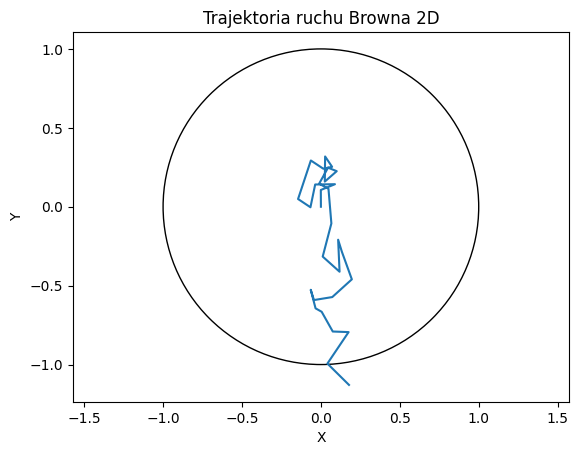

średni czas wyjścia: 0.5610963000000002
wariancja: 0.1561350571263099
Mediana: 0.45000000000000023


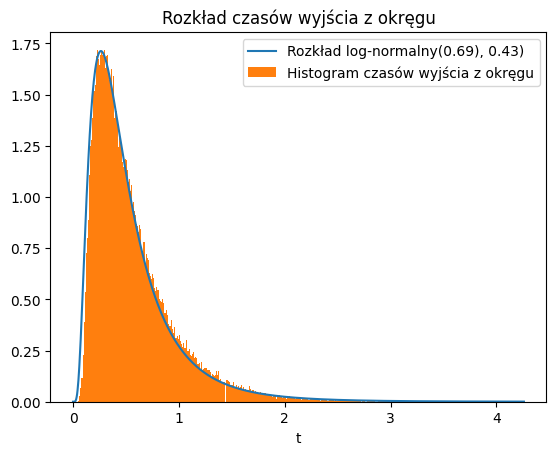

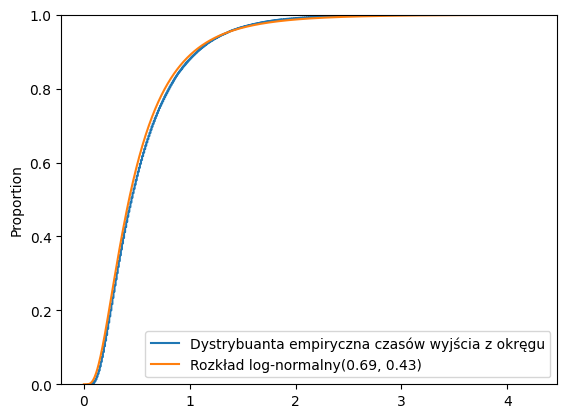

Parametry rozkładu logarytmicznie normalnego: shape=0.6943087065109561, scale=0.4269223804850745
KstestResult(statistic=0.03835327266621891, pvalue=3.02879494997675e-128)


In [18]:

def brownian_motion_2d_draw(dt):
    '''
    dt - czas jaki upływa między kolejnymi krokami

    Generuje trajektorię ruchu Browna do momentu opuszczenia koła jednostkowego, generuje wykres tej trajektorii.
    '''
    t = 0
    x = y = 0  # początkowe położenie
    positions = [(x, y)]
    while x**2 + y**2 <= 1:
        dx = np.random.normal(loc=0, scale=np.sqrt(dt))
        dy = np.random.normal(loc=0, scale=np.sqrt(dt))
        x += dx
        y += dy
        t += dt
        positions.append((x, y))
    positions = np.array(positions)
    fig = plt.figure()
    ax = fig.add_subplot()
    circle1 = patches.Circle((0, 0), radius=1, fill=False)
    ax.add_patch(circle1)
    ax.plot(positions[:, 0], positions[:, 1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajektoria ruchu Browna 2D')
    plt.axis('equal')
    plt.show()
    return t

@njit
def brownian_motion_2d_simulation(dt):
    '''
    dt - czas jaki upływa między kolejnymi krokami

    Generuje trajektorię ruchu Browna do momentu opuszczenia koła jednostkowego (bez wykresu).
    '''
    t = 0
    x = y = 0  # początkowe położenie
    while x**2 + y**2 <= 1:
        dx = np.random.normal(loc=0, scale=np.sqrt(dt))
        dy = np.random.normal(loc=0, scale=np.sqrt(dt))
        x += dx
        y += dy
        t += dt
    return t

dt = 0.01  # krok czasowy
N = 10**5 # Liczba symulacji

#Przykładowa trajektoria
brownian_motion_2d_draw(dt)

exit_times = []
for _ in range(N):
    exit_time = brownian_motion_2d_simulation(dt)
    exit_times.append(exit_time)

print(f'średni czas wyjścia: {np.mean(exit_times)}')
print(f'wariancja: {np.var(exit_times)}')
print(f'Mediana: {np.median(exit_times)}')
ts = np.linspace(0, max(exit_times), 1000)

fit_shape, fit_loc, fit_scale  = stats.lognorm.fit(exit_times)
plt.plot(ts, stats.lognorm(fit_shape, 0, fit_scale).pdf(ts), label=f'Rozkład log-normalny({np.round(fit_shape, 2)}), {np.round(fit_scale, 2)})')
plt.hist(exit_times, bins=int(max(exit_times)/dt), density=True, label=f'Histogram czasów wyjścia z okręgu')
plt.title('Rozkład czasów wyjścia z okręgu')
plt.legend()
plt.xlabel('t')
plt.show()

sns.ecdfplot(exit_times, label='Dystrybuanta empiryczna czasów wyjścia z okręgu')
plt.plot(ts, stats.lognorm(fit_shape, 0, fit_scale).cdf(ts), label=f'Rozkład log-normalny({np.round(fit_shape, 2)}, {np.round(fit_scale, 2)})')
plt.legend()
plt.show()

print(f'Parametry rozkładu logarytmicznie normalnego: shape={fit_shape}, scale={fit_scale}')
print(stats.kstest(exit_times, stats.lognorm(fit_shape, 0, fit_scale).cdf))

Z powyższego histogramu można wywnioskować, że czasy wyjścia pochodzą z nieznanego, prawoskośnego rozkładu o średniej równej około $0.56$ oraz wariancji równej około $0.16$. Najbliższym dopasowaniem, jakie udało nam się znaleźć (na podstawie wykresów) jest rozkład logarytmicznie normalny o parametrze kształtu równym około $0.69$ oraz parametrze skali równym w przybliżeniu $0.43$. Nie jest to jednak rozkład, z którego pochodzą dane, ponieważ p-wartość w teście Kołmogorowa-Smirnowa wynosi $0$.